In [3]:
# The dataset : https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset

# Import libraries
import pandas as pd
import numpy as np
import os
from os import path
import string
import re
from tqdm import tqdm


# visualization tools 
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#nlp libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from nltk import pos_tag
from nltk.corpus import wordnet

#ML dependencies
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix

from nltk.tag import PerceptronTagger



In [9]:
# Load the datset
true = pd.read_csv("Data/True.csv")
fake = pd.read_csv("Data/Fake.csv")

In [3]:
'''explore the data'''
true.head(5)


,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [5]:
# check the size of the dataset
c1=len(true)
c0 = len(fake)
true.shape, fake.shape

((21417, 4), (23481, 4))

In [10]:

# its a label for fake (0) and true (1)
true['category'] = 1
fake['category'] = 0

In [11]:
# Now concatenate tru and fake together
df = pd.concat([true,fake])
df.sample(5)  # get random samples

,title,text,subject,date,category
11970,RON PAUL SUMS Up Obama’s #FakePresidency In On...,Ownage. pic.twitter.com/yznLKcYiMW Paul Josep...,politics,"Jan 8, 2017",0
18359,British PM May's voice repeatedly fails in key...,"MANCHESTER, England (Reuters) - British Prime ...",worldnews,"October 4, 2017",1
20090,All the president's women: Duterte's fiercest ...,"DAVAO, Philippines/MANILA (Reuters) - Philippi...",worldnews,"September 14, 2017",1
15355,"SHERIFFS, LT. GOV AND IMMIGRATION EXPERTS FIGH...","Hello America Are we awake yet?AUSTIN, Texas ...",politics,"Aug 7, 2015",0
3775,WATCH: Teacher Busted Calling Black Student A...,A teacher in Maryland is apparently gunning fo...,News,"November 17, 2016",0


([<matplotlib.patches.Wedge at 0x7f1f0e78c730>,
 [Text(0.07936292514234608, 1.097133321940798, 'True'),
  Text(-0.07936282242131068, -1.0971333293712864, 'Fake')],
 [Text(0.043288868259461495, 0.5984363574222533, '47.7%'),
  Text(-0.043288812229805816, -0.598436361475247, '52.3%')])

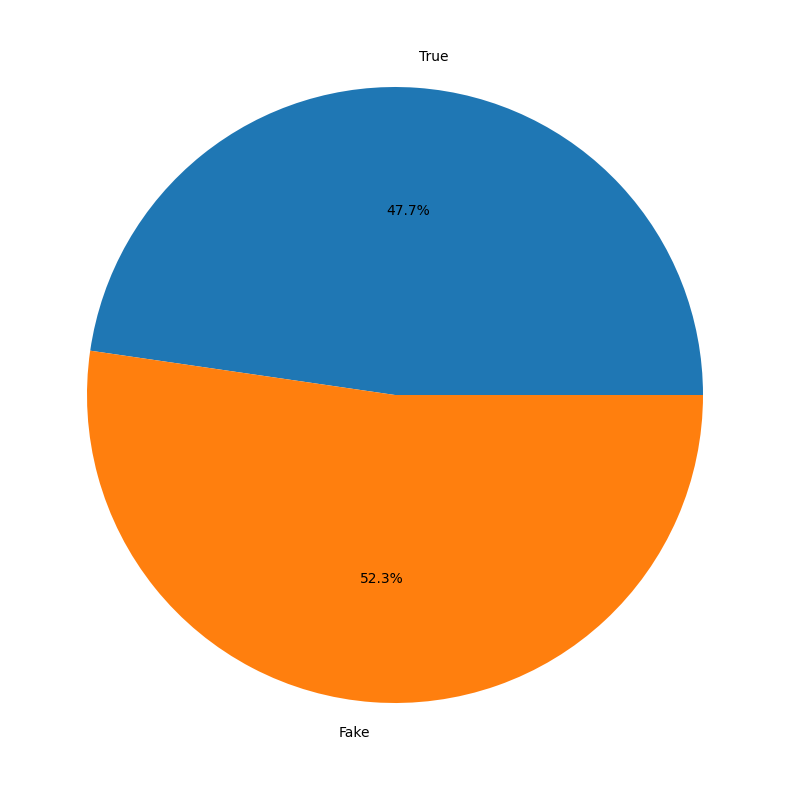

In [82]:
#lets Visualize the dataset spread between true and fake
plt.figure(figsize=(10,10))
plt.pie([c1,c0], labels = ['True','Fake'], autopct = '%1.1f%%')


In [12]:
# fairly balanced dataset
# check to see if there is any nulls
#df.isna().sum()
df.isnull().sum()

title       0
text        0
subject     0
date        0
category    0
dtype: int64

In [13]:
# Check if there is duplicated datapoints
df["is_duplicate"] = df.duplicated()
df[df["is_duplicate"]==True].count() 



title           209
text            209
subject         209
date            209
category        209
is_duplicate    209
dtype: int64

In [14]:
# drop duplicates
print("Number of data points before dropping duplicates: {} \n".format(df.shape[0]))
df.drop_duplicates(keep=False, inplace=True, ignore_index=True)
df.drop("is_duplicate", axis=1, inplace=True) 
print("Number of data points after dropping duplicates: {} \n".format(df.shape[0]))



Number of data points before dropping duplicates: 44898 

Number of data points after dropping duplicates: 44881 



In [15]:
# Let's visulaize the numbers 
df.subject.value_counts()

politicsNews       11255
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

Text(0, 0.5, 'Number of datapoints')

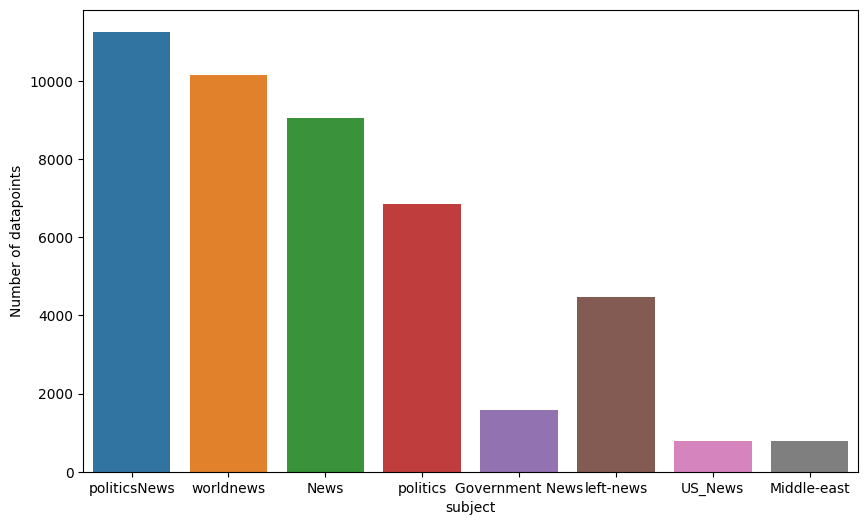

In [16]:
plt.figure(figsize =(10,6))
sns.countplot(x=df.subject)
plt.ylabel("Number of datapoints")

In [17]:
# Let's create the Corpus that will be used in our NLP model
# Create a single column with all the relevant text

df['text'] = df['title']+" "+df['text']


In [18]:

#Now let's delete all other columnswe don't need
del df['title'] 
del df['date']   # Is date useful?
del df['subject']  # This might affect our results

In [ ]:
# downlod the nltk resiurces
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

In [19]:
#Let's clean the corpus
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

ps = PorterStemmer()  # stemming

lemmatizer = WordNetLemmatizer() #lemmatization

# tagger = PerceptronTagger()

def word_cleanse(text):
    text = re.sub('[^a-zA-Z]', ' ',text)
    text = re.sub('\[[^]]*\]', ' ',text) 
    text = re.sub(r'http\S+', ' ',text)
    text = text.lower()
    text = text.split()
    text = [ps.stem(word) for word in text if not word in stop]
    text = ' '.join(text)
    text = [lemmatizer.lemmatize(word) for word in text if not word in stop]
    text = ' '.join(text)
   
    # text = [tagger.tagdict(word) for word in text if not word in stop]
   
    # text = ' '.join(text)
    # print(text)
    
    return text


In [20]:

df['text'].str = df['text'].apply(word_cleanse)
# Save the processed data
#df.to_csv('./Data/processed_data.csv')

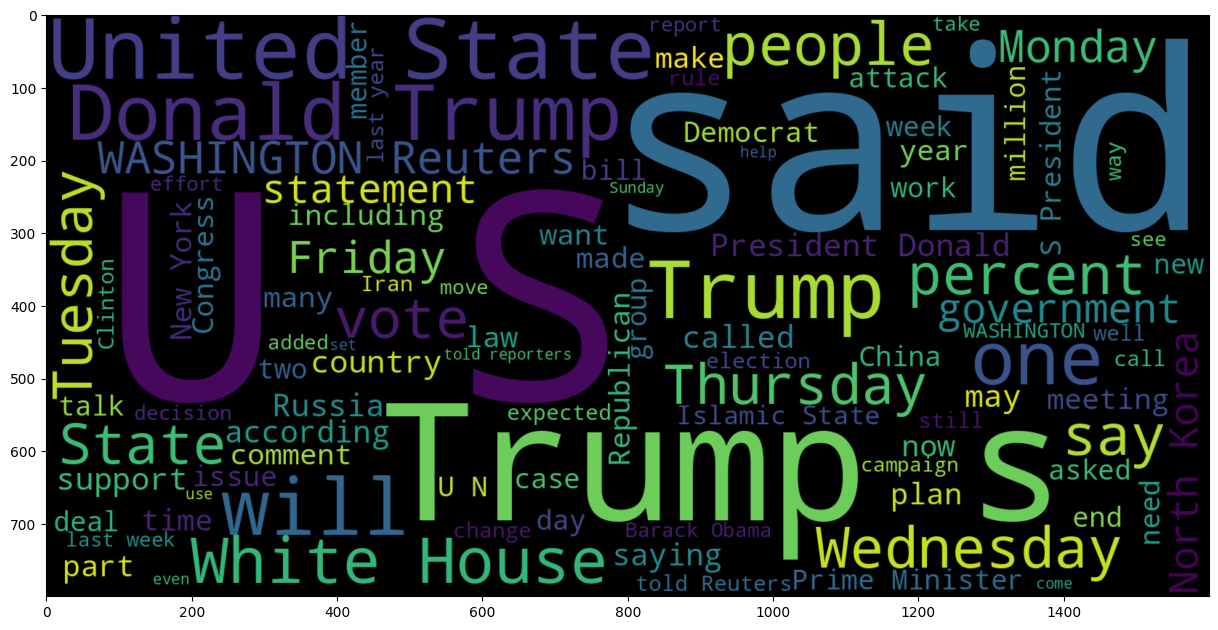

In [21]:
# Let's visualize word frequency

# Most commojn words in real news
plt.figure(figsize=(15,15))
wc1 = WordCloud(max_words=100,width=1600, height=800, stopwords=STOPWORDS).generate(" ".join(df[df.category == 1].text))  # real news
plt.imshow(wc1,interpolation='bilinear')

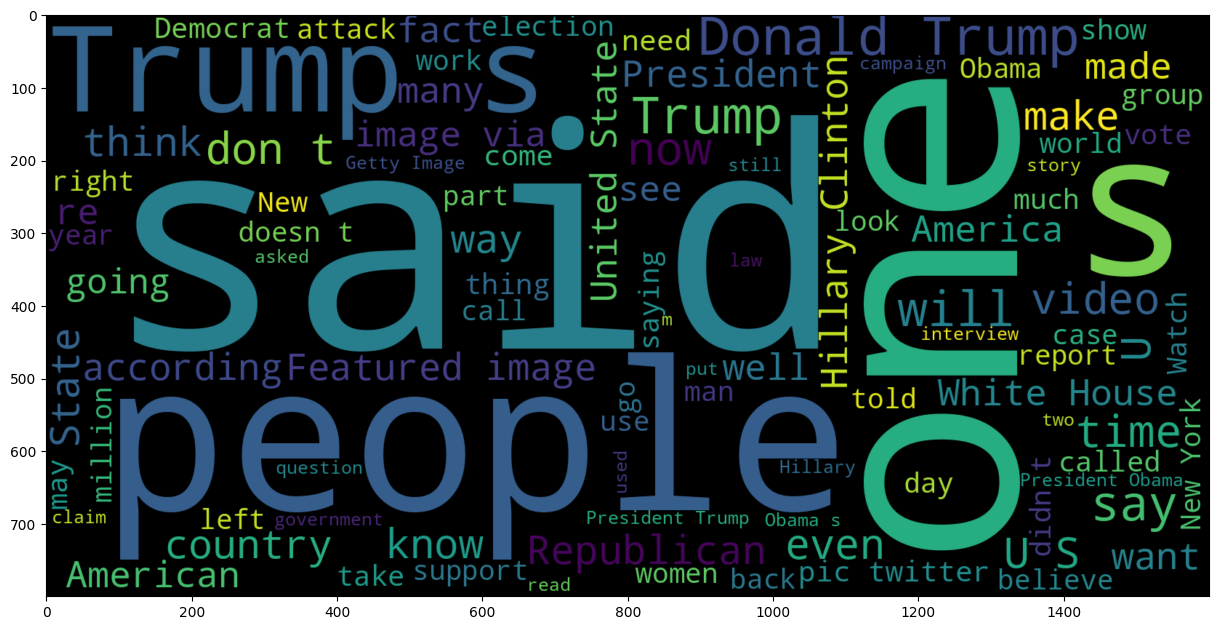

In [22]:
# Most commojn words in fake news
plt.figure(figsize=(15,15))
wc0 = WordCloud(max_words=100,width=1600, height=800, stopwords=STOPWORDS).generate(" ".join(df[df.category == 0].text)) #fake_news
plt.imshow(wc0,interpolation='bilinear')

Text(0.5, 0.98, 'Characters per article')

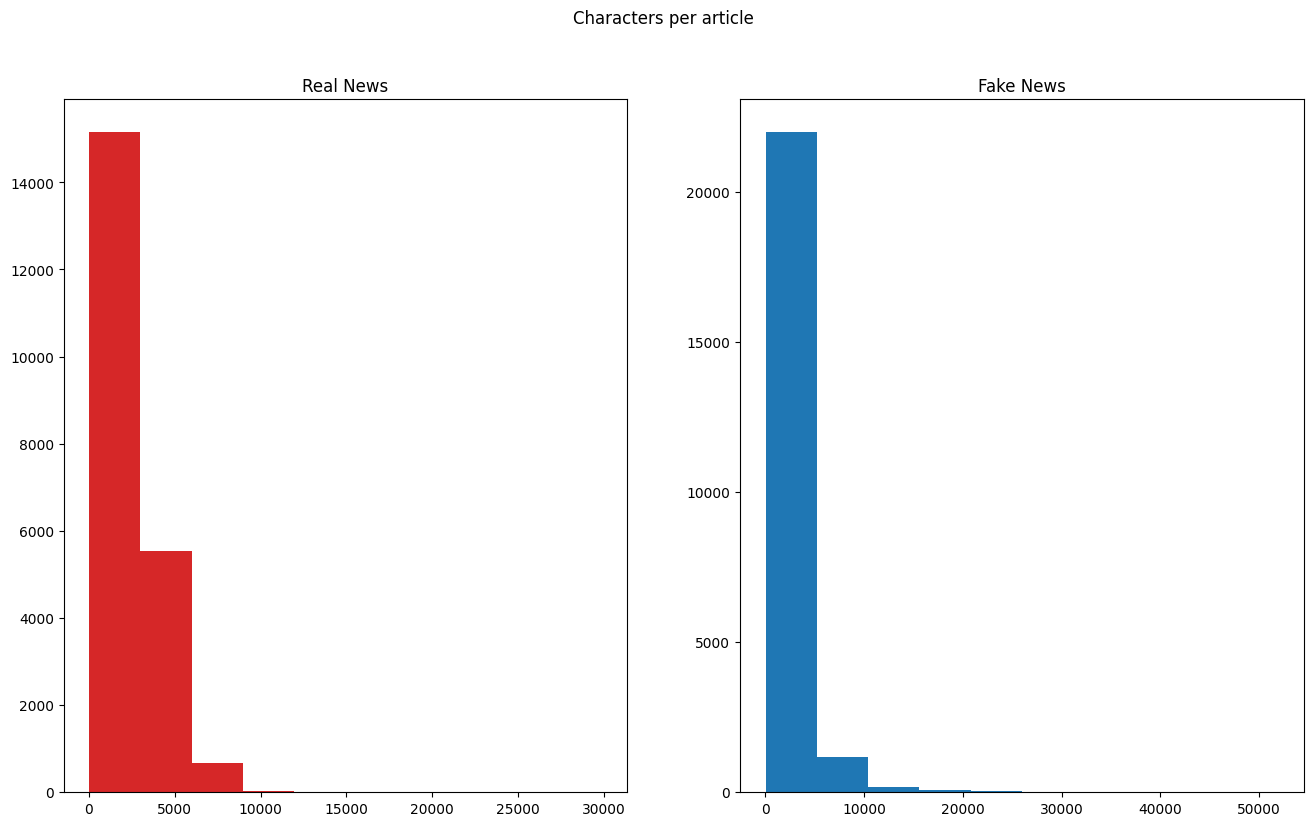

In [23]:
# display characters per article (one data point)
fig,(sub1,sub2) = plt.subplots(1,2,figsize =(16,9)) 
text_len =  df[df['category'] ==1]['text'].str.len()
sub1.hist(text_len,color='tab:red')
sub1.set_title('Real News')
text_len = df[df['category'] ==0]['text'].str.len()
sub2.hist(text_len,color='tab:blue')
sub2.set_title('Fake News')
fig.suptitle('Characters per article')

Text(0.5, 0.98, 'Number of words in text')

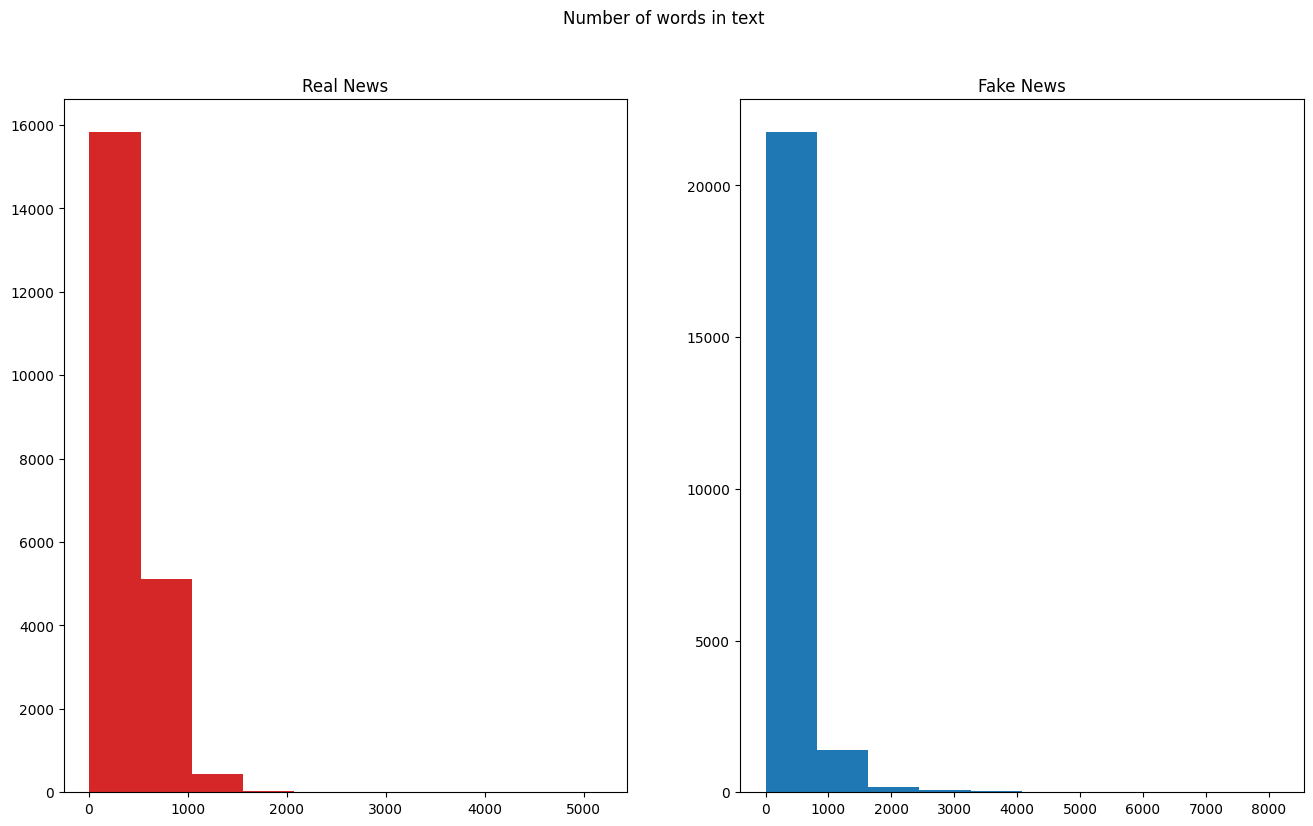

In [24]:
# display number of words in text
fig,(sub1,sub2) = plt.subplots(1,2,figsize =(16,9)) 
text_len =  df[df['category'] ==1]['text'].str.split().map(lambda x:len(x))
sub1.hist(text_len,color='tab:red')
sub1.set_title('Real News')
text_len =  df[df['category'] ==0]['text'].str.split().map(lambda x:len(x))
sub2.hist(text_len,color='tab:blue')
sub2.set_title('Fake News')
fig.suptitle('Number of words in text')

In [ ]:

''' Task 3: Use Pos Tags , modified the text to just nouns+adjectives'''
# This part seems to reduce the accuracy.
tagger = PerceptronTagger()
def pos(text):
    text = text.lower()
    text = text.split()
    #print(text)
    text = tagger.tag(text)
    #print(text)
    res = [word[0] for word in text if word[1]=='NN' or word[1] =='NNS' or word[1]=='NNP' or word[1]=='NNPS' or word[1] =='JJR' or word[1] == 'JJS']
    #print(res)
    res = ' '.join(res)
    return res


i = 0 
for text in tqdm(df.text): 
    l = len(df.text)
    tess = pos(text)
    df['text'][i] = tess
    i+=1
    if i >l:
        break
#print(df['text'])

In [14]:
# Let's do the modeling 

X = df.text
y= df.category

# step1: split training test set
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7,stratify=y,random_state=19)
# print(X_test.shape)
# print(X_train.shape)
# print(X.shape)

In [15]:
# Create a count vectorize object
cv = CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))

#Transform the train dataset
cv_train = cv.fit_transform(X_train)

#Transform the test dataset
cv_test = cv.transform(X_test)

print('Bag of words Train:' ,cv_train.shape)
print('Bag of words Test:' ,cv_test.shape)

Bag of words Train: (31416, 3819833)
Bag of words Test: (13465, 3819833)


In [16]:
# create the TF-IDF object
tfidf = TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))

#Transform the train dataset
tfidf_train = tfidf.fit_transform(X_train)

#Transform the test dataset
tfidf_test = tfidf.transform(X_test)

print('TF-IDF Train:' ,tfidf_train.shape)
print('TF-IDF Test:' ,tfidf_test.shape)

TF-IDF Train: (31416, 3819833)
TF-IDF Test: (13465, 3819833)


In [17]:
#create our model object - Multinomial Naive Bayes
mb = MultinomialNB()

#fit the model to the bag of words CounteVectorizer
mb_cv = mb.fit(cv_train,y_train)

#fit the model to the TF-IDF features
mb_tfidf = mb.fit(tfidf_train,y_train)

In [18]:
#predicting the model for bag of words
mb_cv_predict = mb.predict((cv_test))

#predicting the model for tf-idf
mb_tfidf_predict = mb.predict(tfidf_test)

In [19]:
# Accuracy score for bag of Words
mb_cv_score = accuracy_score(y_test, mb_cv_predict)
print("Naive Bayes Bag of words accuracy score:", mb_cv_score)

#Accuracy score for TF-IDF 
mb_tfidf_score = accuracy_score(y_test,mb_tfidf_predict)
print("Naive Bayes TF-IDF accuracy score:", mb_tfidf_score)


Naive Bayes Bag of words accuracy score: 0.9197920534719644
Naive Bayes TF-IDF accuracy score: 0.8929075380616412


In [20]:
mb_cv_report = classification_report(y_test,mb_cv_predict, target_names =['0','1'])
print(mb_cv_report)

mb_tfidf_report = classification_report(y_test,mb_tfidf_predict, target_names =['0','1'])
print(mb_tfidf_report)

              precision    recall  f1-score   support

           0       0.91      0.94      0.92      7045
           1       0.93      0.90      0.91      6420

    accuracy                           0.92     13465
   macro avg       0.92      0.92      0.92     13465
weighted avg       0.92      0.92      0.92     13465

              precision    recall  f1-score   support

           0       0.85      0.97      0.90      7045
           1       0.96      0.81      0.88      6420

    accuracy                           0.89     13465
   macro avg       0.90      0.89      0.89     13465
weighted avg       0.90      0.89      0.89     13465



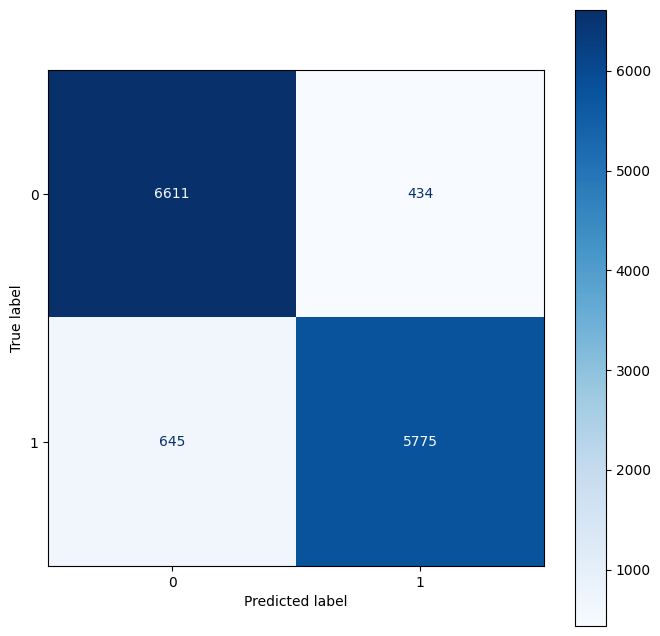

In [105]:

def cm_plot(predictions, labels):
  fig = plt.figure(figsize=(8, 8))
  ax = fig.add_subplot(1, 1, 1)
  cm = metrics.confusion_matrix(labels, predictions)
  cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(2))
  cm.plot(values_format='d', cmap='Blues', ax=ax)

cm_plot(mb_cv_predict,y_test) # confusion matrix for count vectorizer method



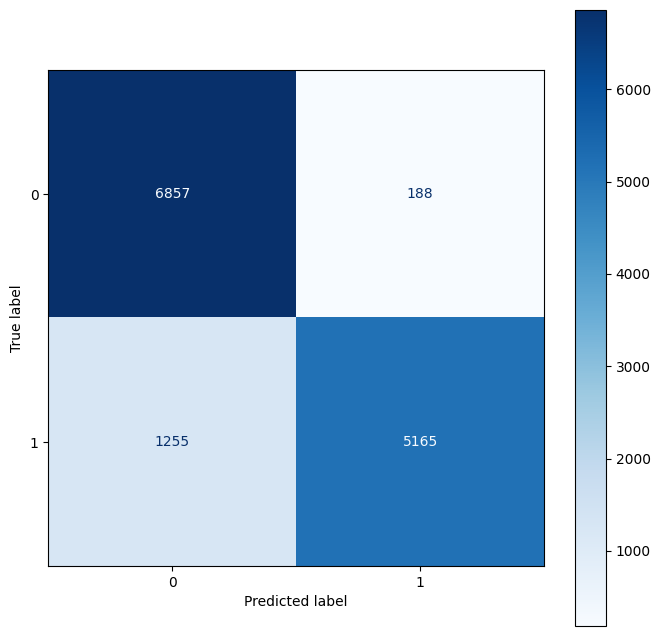

In [106]:
cm_plot(mb_tfidf_predict,y_test) # confusion matrix for tf-idf

In [ ]:
# Creating the classification model and fitting the training data to it
lr = LogisticRegression(C=2.5)

#fit the model to the bag of words CounteVectorizer
lr_cv = lr.fit(cv_train,y_train)

#fit the model to the TF-IDF features
lr_tfidf = lr.fit(tfidf_train,y_train)

In [ ]:
#predicting the model for bag of words
lr_cv_predict = lr.predict((cv_test))

#predicting the model for tf-idf
lr_tfidf_predict = lr.predict(tfidf_test)

In [ ]:
# Accuracy score for bag of Words
lr_cv_score = accuracy_score(y_test, lr_cv_predict)
print("Log Reg Bag of words accuracy score:", lr_cv_score)

#Accuracy score for TF-IDF 
lr_tfidf_score = accuracy_score(y_test,lr_tfidf_predict)
print("Log Reg TF-IDF accuracy score:", lr_tfidf_score)

In [ ]:
lr_cv_report = classification_report(y_test,lr_cv_predict, target_names =['0','1'])
print(lr_cv_report)

lr_tfidf_report = classification_report(y_test,lr_tfidf_predict, target_names =['0','1'])
print(lr_tfidf_report)

In [ ]:

def cm_plot(predictions, labels):
  fig = plt.figure(figsize=(8, 8))
  ax = fig.add_subplot(1, 1, 1)
  cm = metrics.confusion_matrix(labels, predictions)
  cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(2))
  cm.plot(values_format='d', cmap='Blues', ax=ax)

cm_plot(lr_cv_predict,y_test)

In [ ]:
cm_plot(lr_tfidf_predict,y_test)